# Demo: Compressing ground states of molecular hydrogen

In this demo, we will try to compress ground states of molecular hydrogen at various bond lengths. We start with expressing each state using 4 qubits and try to compress the information to 1 qubit (i.e. 4-1-4 quantum autoencoder).

In the following section, we review both the full and halfway training schemes. However, in the notebook, we execute the halfway training case.

## Full cost function training

The QAE circuit for full cost function training looks like the following:

<img src="../images/qae_setup.png" width="400">

We note that our setup is different from what was proposed in the original paper. As shown in the figure above, we use 7 total qubits for the 4-1-4 autoencoder, using the last 3 qubits (qubits $q_6$, $q_5$, and $q_4$) as refresh qubits. The unitary $S$ represents the state preparation circuit, gates implemented to produce the input data set. The unitary $U$ represents the training circuit that will be responsible for representing the data set using a fewer number of qubits, in this case using a single qubit. The tilde symbol above the daggered operations indicates that the qubit indexing has been adjusted such that $q_0 \rightarrow q_6$, $q_1 \rightarrow q_5$, $q_2 \rightarrow q_4$, and $q_3 \rightarrow q_3$. For clarity, refer to the figure below for an equivalent circuit with the refresh qubits moved around. So qubit $q_3$ is to be the "latent space qubit," or qubit to hold the compressed information. Using the circuit structure above (applying  $S$ and $U$ then effectively __un__-applying $S$ and $U$), we train the autoencoder by propagating the QAE circuit with proposed parameters and computing the probability of obtaining measurements of 0000 for the latent space and refresh qubits ($q_3$ to $q_6$). We negate this value for casting as a minimization problem and average over the training set to compute a single loss value.

<img src="../images/qae_adjusted.png" width="500">

## Halfway cost function training

In the halfway cost function training case, the circuit looks like the following:

<img src="../images/h2_halfway_circuit.png" width="300">

Here, the cost function is the negated probability of obtaining the measurement 000 for the trash qubits.


## Demo Outline

We break down this demo into the following steps:
1. Preparation of the quantum data
2. Initializing the QAE
2. Setting up the Forest connection
3. Dividing the dataset into training and test sets
4. Training the network
5. Testing the network

__NOTE__: While the QCompress framework was developed to execute on both the QVM and the QPU (i.e. simulator and quantum device, respectively), this particular demo runs a simulation (i.e. uses QVM).

Let us begin! 

In [1]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_sparse_operator, jordan_wigner
from openfermion.utils import get_ground_state

from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil import Program

from grove.alpha.arbitrary_state import arbitrary_state

from qcompress.qae_engine import *
from qcompress.utils import *
from qcompress.config import DATA_DIRECTORY

global pi
pi = np.pi

## QAE Settings

In the cell below, we enter the settings for the QAE.

__NOTE__: Because QCompress was designed to run on the quantum device (as well as the simulator), we need to anticipate nontrival mappings between abstract qubits and physical qubits. The dictionaries `q_in`,  `q_latent`, and `q_refresh` are abstract-to-physical qubit mappings for the input, latent space, and refresh qubits respectively. A cool plug-in/feature to add would be to have an automated "qubit mapper" to determine the optimal or near-optimal abstract-to-physical qubit mappings for a particular QAE instance.

In [2]:
### QAE setup options

# Abstract-to-physical qubit mapping
q_in = {'q0': 0, 'q1': 1, 'q2': 2, 'q3': 3} # Input qubits
q_latent = {'q3': 3}                        # Latent space qubits
q_refresh = None

# Training scheme: Halfway
trash_training = True

# Simulator settings
cxn_setting = '9q-generic-qvm'
n_shots = 3000

## Qubit labeling

In the cell below, we produce lists of __ordered__ physical qubit indices involved in the compression and recovery maps of the quantum autoencoder. Depending on the training and reset schemes, we may use different qubits for the compression vs. recovery.

Since we're employing the halfway training scheme, we don't need to assign the qubit labels for the recovery process.

In [3]:
compression_indices = order_qubit_labels(q_in).tolist()

if not trash_training:
    q_out = merge_two_dicts(q_latent, q_refresh)
    recovery_indices = order_qubit_labels(q_out).tolist()

    if not reset:
        recovery_indices = recovery_indices[::-1]

print("Physical qubit indices for compression : {0}".format(compression_indices))

Physical qubit indices for compression : [0, 1, 2, 3]


# Generating input data

We use routines from `OpenFermion`, `forestopenfermion`, and `grove` to generate the input data set. We've provided the molecular data files for you, which were generated using `OpenFermion`'s plugin `OpenFermion-Psi4`.

In [4]:
qvm = WavefunctionSimulator()

# MolecularData settings
molecule_name = "H2"
basis = "sto-3g"
multiplicity = "singlet"
dist_list = np.arange(0.2, 4.2, 0.1)

# Lists to store HF and FCI energies
hf_energies = []
fci_energies = []
check_energies = []

# Lists to store state preparation circuits
list_SP_circuits = []
list_SP_circuits_dag = []

for dist in dist_list:
    
    # Fetch file path
    dist = "{0:.1f}".format(dist)
    file_path = os.path.join(DATA_DIRECTORY, "{0}_{1}_{2}_{3}.hdf5".format(molecule_name,
                                                                    basis,
                                                                    multiplicity,
                                                                    dist))
    
    # Extract molecular info
    molecule = MolecularData(filename=file_path)
    n_qubits = molecule.n_qubits
    hf_energies.append(molecule.hf_energy)
    fci_energies.append(molecule.fci_energy)
    molecular_ham = molecule.get_molecular_hamiltonian()
    
    # Set up hamiltonian in qubit basis
    qubit_ham = jordan_wigner(molecular_ham)

    # Convert from OpenFermion's to PyQuil's data type (QubitOperator to PauliTerm/PauliSum)
    qubit_ham_pyquil = qubitop_to_pyquilpauli(qubit_ham)

    # Sanity check: Obtain ground state energy and check with MolecularData's FCI energy
    molecular_ham_sparse = get_sparse_operator(operator=molecular_ham, n_qubits=n_qubits)
    ground_energy, ground_state = get_ground_state(molecular_ham_sparse)
    assert np.isclose(molecule.fci_energy, ground_energy)
    
    # Generate unitary to prepare ground states
    state_prep_unitary = arbitrary_state.create_arbitrary_state(
                            ground_state,
                            qubits=compression_indices)

    if not trash_training:
        if reset:
            # Generate daggered state prep unitary (WITH NEW/ADJUSTED INDICES!)
            state_prep_unitary_dag = arbitrary_state.create_arbitrary_state(
                                        ground_state,
                                        qubits=compression_indices).dagger()
        else:
            # Generate daggered state prep unitary (WITH NEW/ADJUSTED INDICES!)
            state_prep_unitary_dag = arbitrary_state.create_arbitrary_state(
                                        ground_state,
                                        qubits=recovery_indices).dagger()
    
    # Sanity check: Compute energy wrt wavefunction evolved under state_prep_unitary
    wfn = qvm.wavefunction(state_prep_unitary)
    ket = wfn.amplitudes
    bra = np.transpose(np.conjugate(wfn.amplitudes))
    ham_matrix = molecular_ham_sparse.toarray()
    energy_expectation = np.dot(bra, np.dot(ham_matrix, ket))
    check_energies.append(energy_expectation)
    
    # Store circuits
    list_SP_circuits.append(state_prep_unitary)
    if not trash_training:
        list_SP_circuits_dag.append(state_prep_unitary_dag)

### Try plotting the energies of the input data set.

To (visually) check our state preparation circuits, we run these circuits and plot the energies. The "check" energies overlay nicely with the FCI energies.

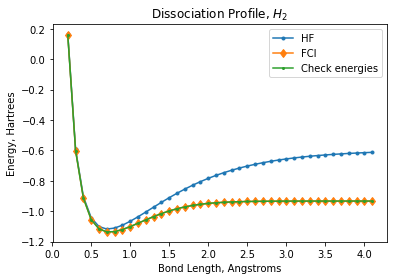

In [5]:
imag_components = np.array([E.imag for E in check_energies])
assert np.isclose(imag_components, np.zeros(len(imag_components))).all()
check_energies = [E.real for E in check_energies]

plt.plot(dist_list, hf_energies, '.-', label='HF')
plt.plot(dist_list, fci_energies, 'd-', markersize=6, label='FCI')
plt.plot(dist_list, check_energies, '.-', markersize=4, label='Check energies')
plt.title("Dissociation Profile, $H_2$")
plt.xlabel("Bond Length, Angstroms")
plt.ylabel("Energy, Hartrees")
plt.legend()
plt.show()

## Training circuit for QAE

Now we want to choose a parametrized circuit which we hope to train to compress the input quantum data set.

For this demonstration, we use a simple two-parameter circuit, as shown below.

__NOTE__: For more general data sets (and general circuits), we may need to run multiple instances of the QAE with different initial guesses to find a good compression circuit.

In [6]:
def _training_circuit(theta, qubit_indices):
    """
    Returns parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(RX(theta[0], qubit_indices[2]),
                       RX(theta[1], qubit_indices[3]))
    circuit += Program(CNOT(qubit_indices[2], qubit_indices[0]),
                       CNOT(qubit_indices[3], qubit_indices[1]),
                       CNOT(qubit_indices[3], qubit_indices[2]))
    return circuit

def _training_circuit_dag(theta, qubit_indices):
    """
    Returns the daggered parametrized/training circuit.
    
    :param theta: (list or numpy.array, required) Vector of training parameters
    :param qubit_indices: (list, required) List of qubit indices
    :returns: Daggered training circuit
    :rtype: pyquil.quil.Program
    """
    circuit = Program()
    circuit += Program(CNOT(qubit_indices[3], qubit_indices[2]),
                       CNOT(qubit_indices[3], qubit_indices[1]),
                       CNOT(qubit_indices[2], qubit_indices[0]))
    circuit += Program(RX(-theta[1], qubit_indices[3]),
                       RX(-theta[0], qubit_indices[2]))
    return circuit

In [7]:
training_circuit = lambda param : _training_circuit(param, compression_indices)

if not trash_training:
    if reset:
        training_circuit_dag = lambda param : _training_circuit_dag(param, compression_indices)
    else:
        training_circuit_dag = lambda param : _training_circuit_dag(param, recovery_indices)

## Initialize the QAE engine

Here we create an instance of the `quantum_autoencoder` class. 


Leveraging the features of the `Forest` platform, this quantum autoencoder "engine" allows you to run a noisy version of the QVM to get a sense of how the autoencoder performs under noise (but qvm is noiseless in this demo). In addition, the user can also run this instance on the quantum device (assuming the user is given access to one of Rigetti Computing's available QPUs).

In [8]:
qae = quantum_autoencoder(state_prep_circuits=list_SP_circuits,
                          training_circuit=training_circuit,
                          q_in=q_in,
                          q_latent=q_latent,
                          q_refresh=q_refresh,
                          trash_training=trash_training,
                          parametric_compilation=False,
                          n_shots=n_shots, 
                          print_interval=1)

After defining the instance, we set up the Forest connection (in this case, a simulator).

In [9]:
qae.setup_forest_cxn(cxn_setting)

Let's split the data set into training and test set. If we don't input the argument `train_indices`, the data set will be randomly split. However, knowing our quantum data set, we may want to choose various regions along the PES (the energy curve shown above) to train the entire function. Here, we pick 6 out of 40 data points for our training set.

In [10]:
qae.train_test_split(train_indices=[3, 10, 15, 20, 30, 35])

Let's print some information about the QAE instance.

In [11]:
print(qae)

QCompress Setting
QAE type: 4-1-4
Data size: 40
Training set size: 6
Training mode: halfway cost function
Parametric compilation: False
Forest connection: 9q-generic-qvm
  Connection type: QVM


## Training

The autoencoder is trained in the cell below, where the default optimization algorithm is Constrained Optimization BY Linear Approximation (COBYLA). The lowest possible mean loss value is -1.000.

In [12]:
%%time

initial_guess = [pi/2., 0.]
avg_loss_train = qae.train(initial_guess)

Iter    0 Mean Loss: -0.0000000
Iter    1 Mean Loss: -0.0000000
Iter    2 Mean Loss: -0.0016667
Iter    3 Mean Loss: -0.0051667
Iter    4 Mean Loss: -0.0102778
Iter    5 Mean Loss: -0.0169444
Iter    6 Mean Loss: -0.0228889
Iter    7 Mean Loss: -0.0338889
Iter    8 Mean Loss: -0.0469444
Iter    9 Mean Loss: -0.0680556
Iter   10 Mean Loss: -0.0770556
Iter   11 Mean Loss: -0.1017778
Iter   12 Mean Loss: -0.1232778
Iter   13 Mean Loss: -0.1575000
Iter   14 Mean Loss: -0.1765556
Iter   15 Mean Loss: -0.2091111
Iter   16 Mean Loss: -0.2426667
Iter   17 Mean Loss: -0.2768889
Iter   18 Mean Loss: -0.3217778
Iter   19 Mean Loss: -0.3468333
Iter   20 Mean Loss: -0.3908889
Iter   21 Mean Loss: -0.4382222
Iter   22 Mean Loss: -0.4856111
Iter   23 Mean Loss: -0.5355556
Iter   24 Mean Loss: -0.5691111
Iter   25 Mean Loss: -0.6148333
Iter   26 Mean Loss: -0.6547778
Iter   27 Mean Loss: -0.6975000
Iter   28 Mean Loss: -0.7463889
Iter   29 Mean Loss: -0.7716111
Iter   30 Mean Loss: -0.8145556
Iter   3

### Printing the optimized parameters

In [13]:
print(qae.optimized_params)

[3.1508787 3.1454069]


### Plot training losses

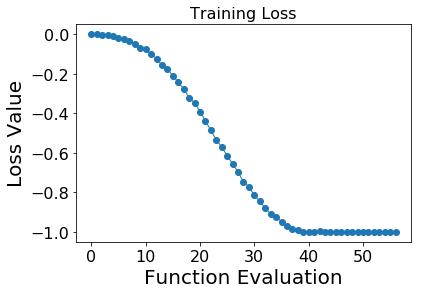

In [14]:
fig = plt.figure(figsize=(6, 4))
plt.plot(qae.train_history, 'o-', linewidth=1)
plt.title("Training Loss", fontsize=16)
plt.xlabel("Function Evaluation",fontsize=20)
plt.ylabel("Loss Value", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

## Testing

Now test the optimized network against the rest of the data set (i.e. use the optimized parameters to try to compress then recover each test data point).

In [15]:
avg_loss_test = qae.predict()

Iter   57 Mean Loss: -0.9999412
Mean loss for test data: -0.9999411764705881
